# **About Dataset**

**Context**

Predict next-day rain by training classification models on the target variable RainTomorrow.

**Content**

This dataset contains about 10 years of daily weather observations from many locations across Australia.

RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

# **Imports**

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split , cross_val_score , RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score , classification_report , accuracy_score , confusion_matrix 

In [2]:
df = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# **Explore the Dataset**

In [3]:
df.shape

(145460, 23)

In [4]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [6]:
# describtion for numerical columns
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


# **Deal with missing values**

In [7]:
# calculating missing values
(df.isna().sum().sort_values(ascending = False)) / len(df)

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
Temp9am          0.012148
WindSpeed9am     0.012148
MinTemp          0.010209
MaxTemp          0.008669
Location         0.000000
Date             0.000000
dtype: float64

In [8]:
# Categorical columns that have missing values
df_cat = df.select_dtypes(include = ['object'])

(df_cat.isna().sum().sort_values(ascending = False)) / len(df)

WindDir9am      0.072639
WindGustDir     0.070989
WindDir3pm      0.029066
RainTomorrow    0.022460
RainToday       0.022419
Date            0.000000
Location        0.000000
dtype: float64

> we will drop the rows that have a missing values because the number of rows with missing values is relatively small

In [9]:
# Drop the rows with the missing values
for column_name in df_cat.columns:
    df.dropna(subset=[column_name], inplace=True)
    df_cat.dropna(subset=[column_name], inplace=True)

# Check the shape after dropping rows with missing values
df.shape

(123710, 23)

In [10]:
# numerical columns that have missing values
df_num = df.select_dtypes(include = ['float64', 'int64'])

(df_num.isna().sum().sort_values(ascending = False)) / len(df)

Sunshine         0.457708
Evaporation      0.409401
Cloud3pm         0.389888
Cloud9am         0.373729
Pressure9am      0.073721
Pressure3pm      0.073309
Humidity3pm      0.012303
Humidity9am      0.008180
Temp3pm          0.006426
Temp9am          0.002773
MinTemp          0.000728
MaxTemp          0.000364
Rainfall         0.000000
WindGustSpeed    0.000000
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
dtype: float64

> these columns we will filling it by SimpleImputer method in the pipeLine

# # **Data distribution**

# **Numerical columns**

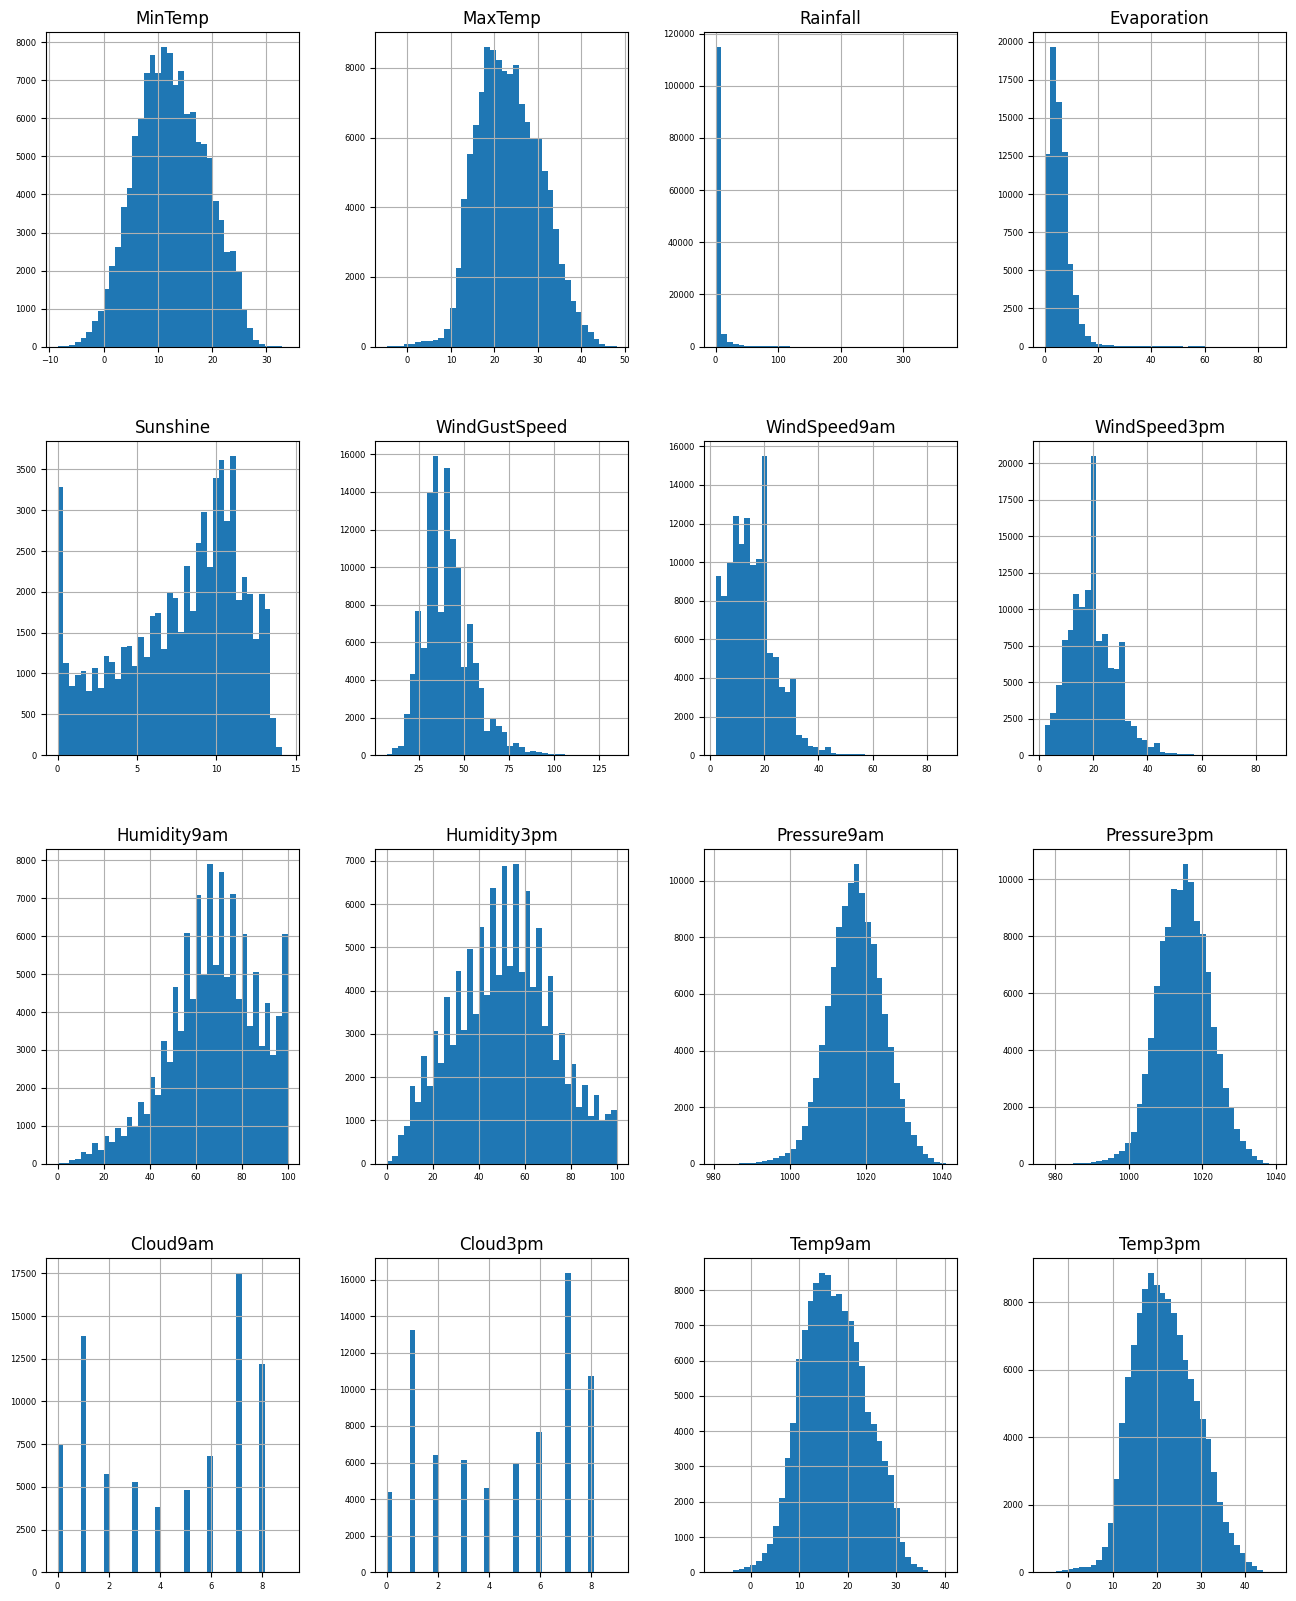

In [11]:
df_num.hist(figsize=(16, 20), bins=40, xlabelsize=6, ylabelsize=6);

In [12]:
# Encoding our target column
replacement_dict = {'Yes': 1, 'No': 0}
df['RainTomorrow'] = df['RainTomorrow'].replace(replacement_dict)

df_num = pd.concat([df_num, df['RainTomorrow']], axis=1)

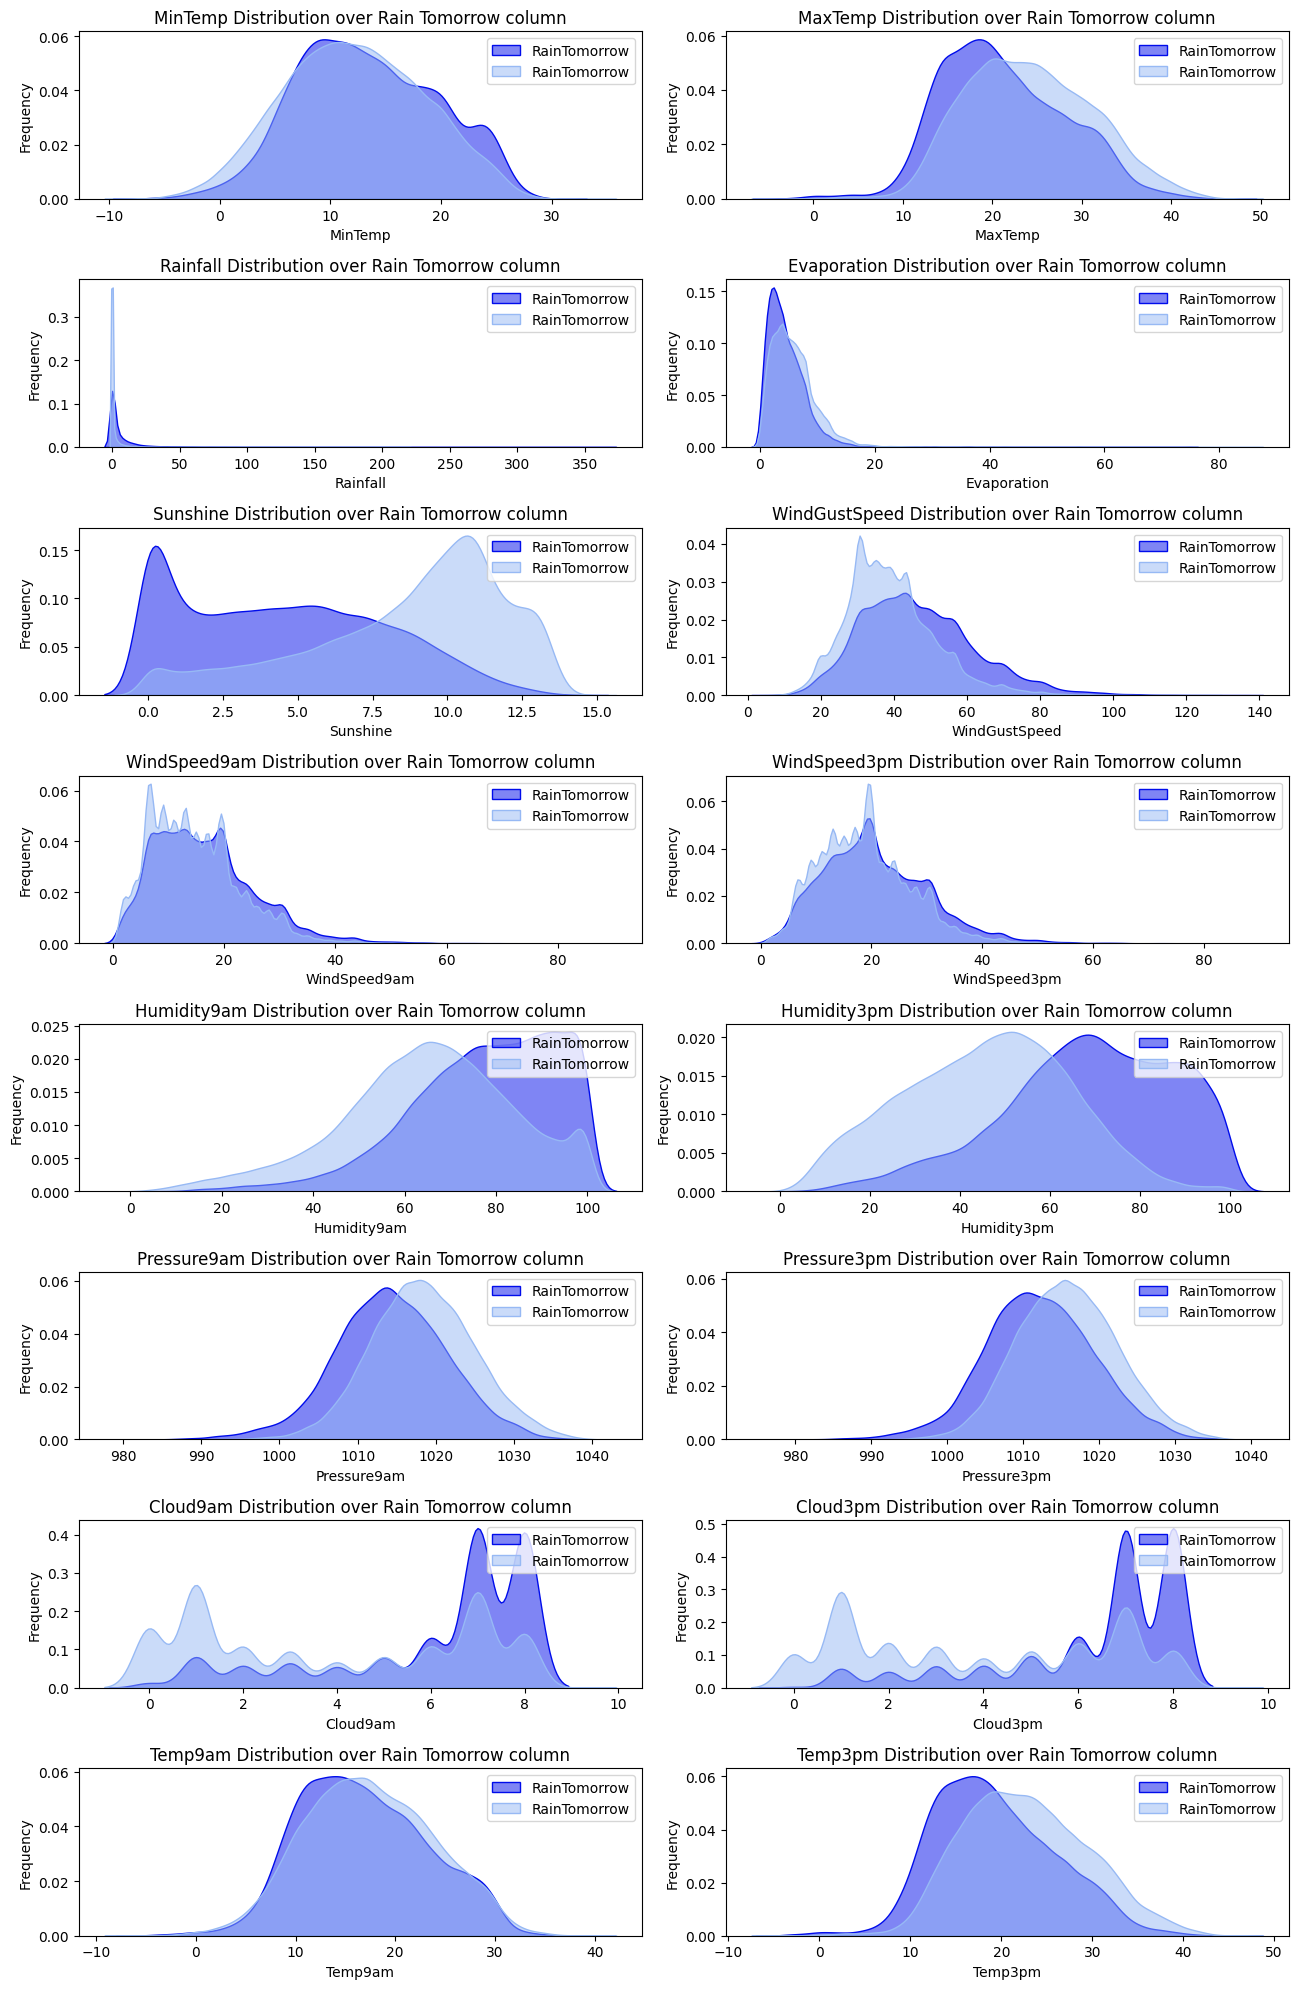

In [13]:
fig, axes = plt.subplots(nrows=len(df_num.columns) // 2, ncols=2, figsize=(13, 20))

for idx, column in enumerate(df_num.drop(columns = 'RainTomorrow')):
    row_idx = idx // 2
    col_idx = idx % 2
    
    sns.kdeplot(df[df["RainTomorrow"] == 1][column], alpha=0.5, fill=True, color="#000CEB", label="RainTomorrow", ax=axes[row_idx, col_idx])
    sns.kdeplot(df[df["RainTomorrow"] == 0][column], alpha=0.5, fill=True, color="#97B9F4", label="RainTomorrow", ax=axes[row_idx, col_idx])
    
    axes[row_idx, col_idx].set_xlabel(column)
    axes[row_idx, col_idx].set_ylabel("Frequency")
    axes[row_idx, col_idx].set_title(f"{column} Distribution over Rain Tomorrow column")
    axes[row_idx, col_idx].legend()

plt.tight_layout()
plt.show()

# **Categorical columns**

**Check for high and low cardinality**

In [14]:
df_cat.nunique().sort_values()

RainToday          2
RainTomorrow       2
WindGustDir       16
WindDir9am        16
WindDir3pm        16
Location          47
Date            3417
dtype: int64

> We will drop Date column cecause it is a high cardinality

In [15]:
df_cat.drop(columns = 'Date', inplace = True)

# **Outliers**

In [16]:
# Outlier Equation
def outlier_thresholds (dataframe, column, q1=0.25, q3=0.75) :
    quartile1 = dataframe[column].quantile(q1)
    quartile3 = dataframe[column].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

# Checking Outliers
def check_outlier(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    outliers = (dataframe[column] > up_limit) | (dataframe[column] < low_limit)
    if outliers.any():
        return True
    else:
        return False

# Removing the outliers
def replace_with_thresholds (dataframe, column) :
    low_limit , up_limit = outlier_thresholds(dataframe, column)
    dataframe.loc[(dataframe[column] < low_limit), column] = low_limit
    dataframe.loc[(dataframe[column] > up_limit), column] = up_limit

**Plotting Outliers**

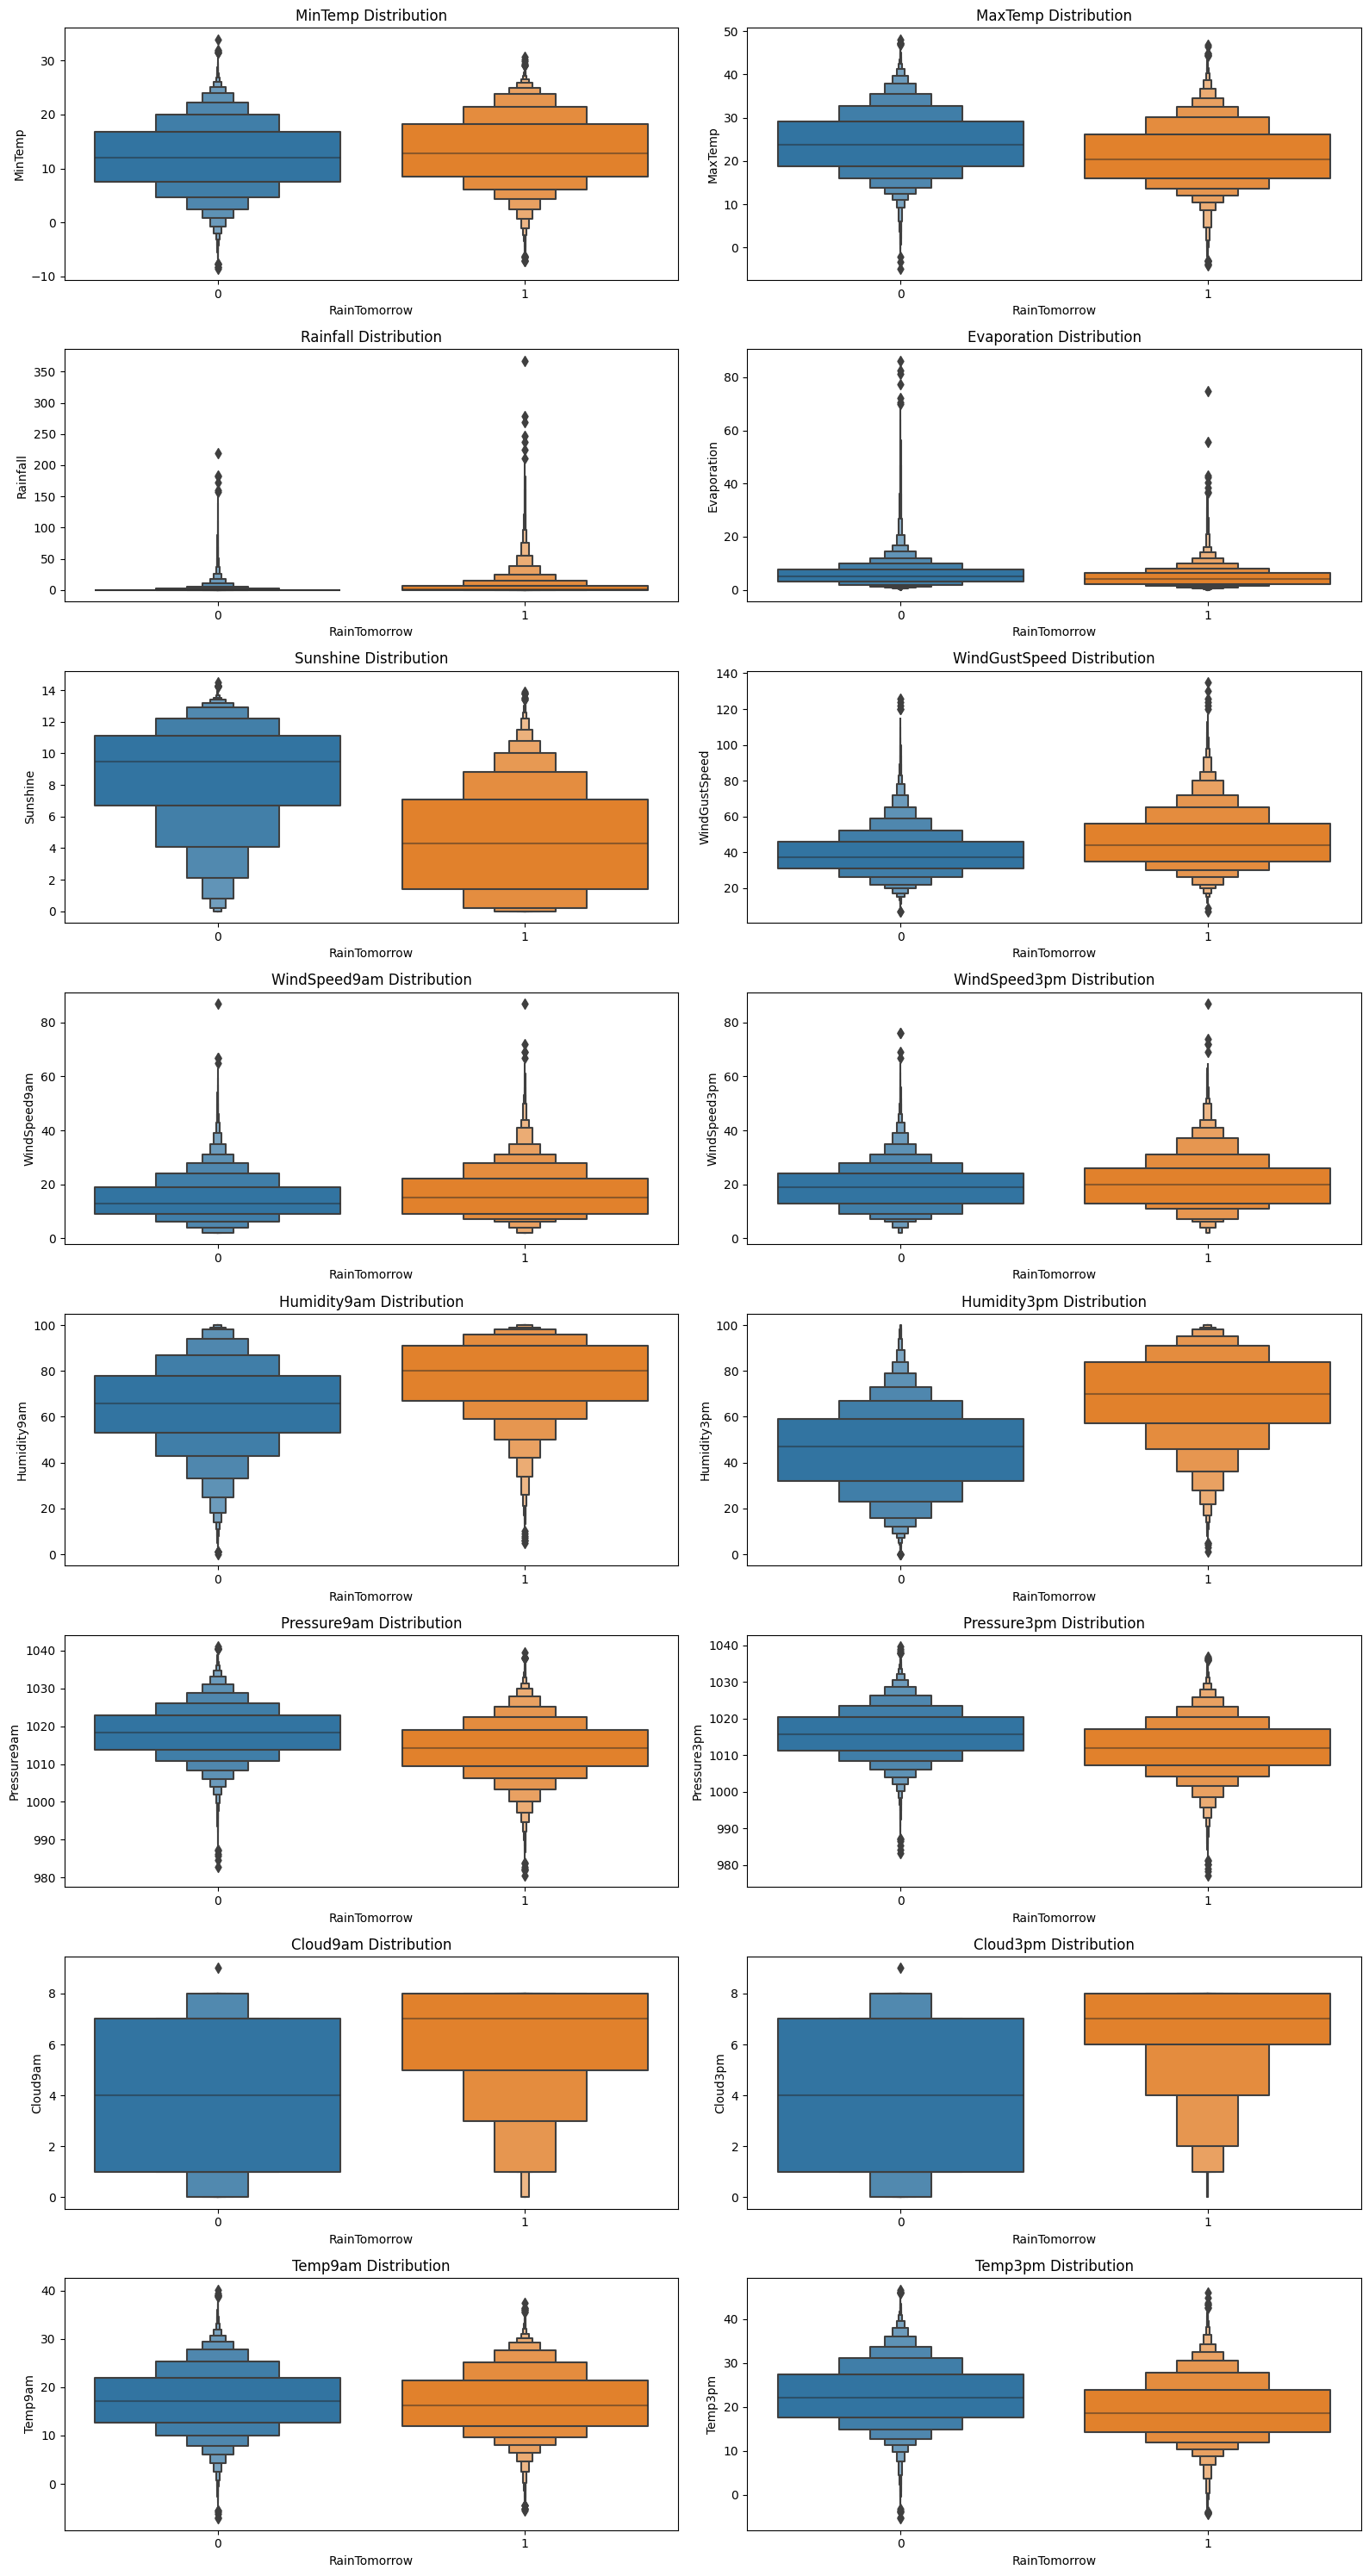

In [17]:
fig, axes = plt.subplots(nrows=len(df_num.columns) // 2, ncols=2, figsize=(16, 30))

for idx, column in enumerate(df_num.drop(columns = 'RainTomorrow')):
    row_idx = idx // 2
    col_idx = idx % 2
    
    sns.boxenplot( x='RainTomorrow' , y= column , data=df, ax=axes[row_idx, col_idx])
    
    axes[row_idx, col_idx].set_xlabel("RainTomorrow")
    axes[row_idx, col_idx].set_ylabel(column)
    axes[row_idx, col_idx].set_title(f"{column} Distribution")

plt.tight_layout()
plt.show()

# **Removing outliers**

In [18]:
print('After removing the outliers :')
for column in (df_num.drop(columns = 'RainTomorrow').columns):
    replace_with_thresholds(df_num, column)
    print(column, check_outlier(df_num, column))

After removing the outliers :
MinTemp False
MaxTemp False
Rainfall False
Evaporation False
Sunshine False
WindGustSpeed False
WindSpeed9am False
WindSpeed3pm False
Humidity9am False
Humidity3pm False
Pressure9am False
Pressure3pm False
Cloud9am False
Cloud3pm False
Temp9am False
Temp3pm False


# **Multicollinearity**

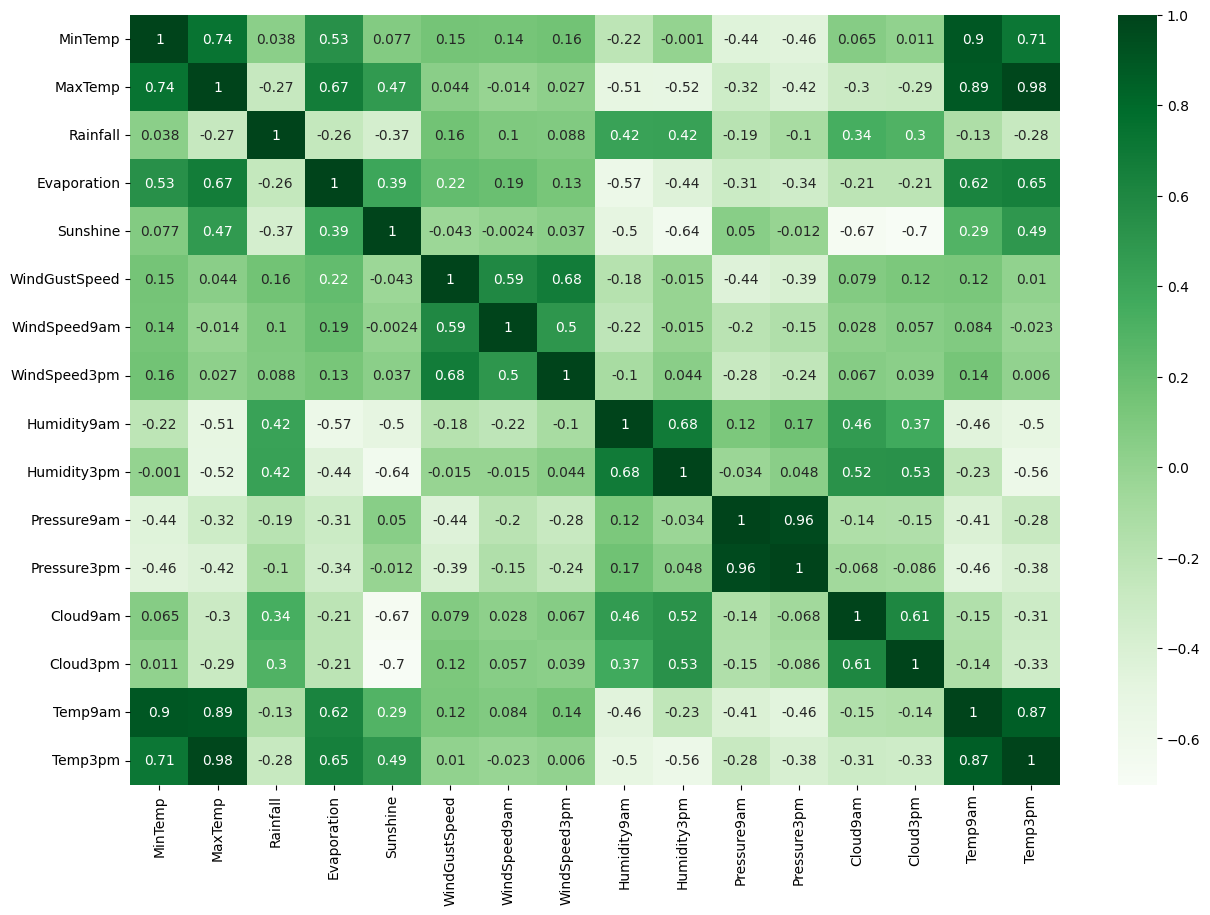

In [19]:
corr = df_num.drop(columns= 'RainTomorrow').corr()
fig , ax = plt.subplots(figsize=(15 , 10))
sns.heatmap(corr ,annot= True , ax=ax , cmap= 'Greens');

**Now we will search for columns that has a correlation more than 70% and drop one of them with the condition that the correlation with the target column (HeartDisease) is smaller than another column**

In [20]:
# check the correlation for columns => MinTemp & MaxTemp with the target
print(f"Correlation between MinTemp and MaxTemp :{df_num['MinTemp'].corr(df_num['MaxTemp'])}")

print(f"Correlation between MinTemp and the target :{df_num['MinTemp'].corr(df_num['RainTomorrow'])}")

print(f"Correlation between MaxTemp and the target :{df_num['MaxTemp'].corr(df_num['RainTomorrow'])}")

Correlation between MinTemp and MaxTemp :0.7388666511216592
Correlation between MinTemp and the target :0.07665743319290642
Correlation between MaxTemp and the target :-0.16826364972329802


In [21]:
# check the correlation for columns => Temp3pm & Temp9am with the target
print(f"Correlation between Temp3pm and Temp9am :{df_num['Temp3pm'].corr(df_num['Temp9am'])}")

print(f"Correlation between Temp3pm and the target :{df_num['Temp3pm'].corr(df_num['RainTomorrow'])}")

print(f"Correlation between Temp9am and the target :{df_num['Temp9am'].corr(df_num['RainTomorrow'])}")

Correlation between Temp3pm and Temp9am :0.8662428488059686
Correlation between Temp3pm and the target :-0.2010760215356986
Correlation between Temp9am and the target :-0.03628023377773611


In [22]:
# drop 'MinTemp' and 'Temp9am' column
df_num.drop(columns = ['MinTemp','Temp9am'], inplace = True)

# **Target balance**

In [23]:
# Recreate our dataframe
df_cat.drop(columns = 'RainTomorrow', inplace = True)
df = pd.concat([df_num, df_cat], axis=1)

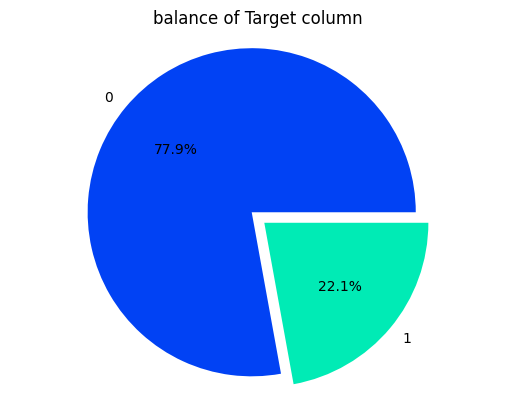

In [24]:
target_column = df.RainTomorrow.value_counts()

# pie chart for target column
plt.pie(target_column, labels = target_column.index, autopct="%1.1f%%", explode = [0,0.1], colors = ["#0142F4","#00EBB5"])
plt.title("balance of Target column")
plt.axis("equal")
plt.show()

> Our data is balanced

# **Splitting data for train and test**

In [25]:
X = df.drop(columns = 'RainTomorrow')
target = df['RainTomorrow']

X_train , X_test , y_train , y_test = train_test_split(X ,target ,test_size=0.2 , random_state=42 )
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (98968, 19)
y_train shape: (98968,)
X_test shape: (24742, 19)
y_test shape: (24742,)


# **Baseline**

In [26]:
dummy_classifier = DummyClassifier(strategy = 'stratified', random_state = 42) 
dummy_classifier.fit(X_train, y_train) 
y_pred = dummy_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Model Accuracy: {accuracy:.4f}")

Baseline Model Accuracy: 0.6587


# **Modeling**

In [27]:
def train(classifier,x_train,y_train,x_test,y_test):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 42)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    

def model_evaluation(classifier,x_test,y_test):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Greens',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

# Random forest

In [28]:
rf_classifier = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(strategy='mean'),
    MinMaxScaler(),
    RandomForestClassifier(n_estimators=25, random_state=42)
)

Cross Validation Score :  87.77%
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     19284
           1       0.75      0.52      0.61      5458

    accuracy                           0.85     24742
   macro avg       0.81      0.73      0.76     24742
weighted avg       0.85      0.85      0.84     24742



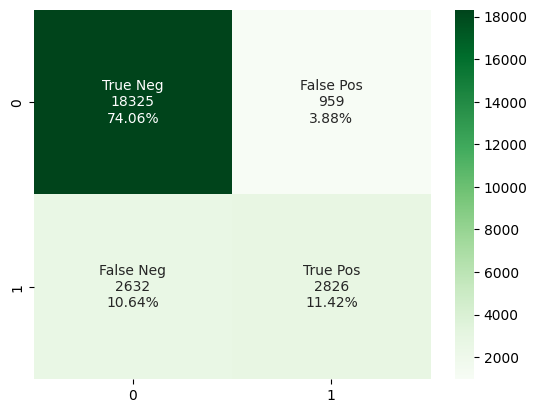

In [29]:
# Training the model
train(rf_classifier, X_train, y_train, X_test, y_test)

# Evaluate the model
model_evaluation(rf_classifier, X_test, y_test)

# XGBoost

In [30]:
xgb_classifier = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(strategy='mean'),
    MinMaxScaler(),
    xgb.XGBClassifier(objective = 'binary:logistic', random_state = 42)
)

Cross Validation Score :  89.61%
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     19284
           1       0.75      0.57      0.65      5458

    accuracy                           0.86     24742
   macro avg       0.82      0.76      0.78     24742
weighted avg       0.86      0.86      0.86     24742



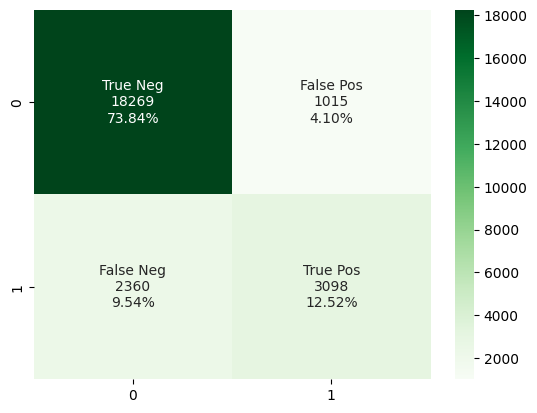

In [31]:
# Training the model
train(xgb_classifier, X_train, y_train, X_test, y_test)

# Evaluate the model
model_evaluation(xgb_classifier, X_test, y_test)